# Analyze H3 AA prefs

This notebook was written by Frances Welsh, and based off of [code from Caelen Radford analyzing BF520](https://github.com/jbloomlab/barcoded_HIV_DMS/tree/main/additional_analyses/BF520_library_design). The purpose of this notebook is to analyze DMS data of influenza H3 in order to determine lethal mutants that should be excluded from a multi-mutant library. This H3 data was generated by Juhye Lee and Rachel Eguia, and can be found [here](https://github.com/jbloomlab/2017-Perth2009-DMS).

In [1]:
import dms_tools2
import pandas as pd
import numpy as np
from plotnine import *
%matplotlib inline

# Make pandas dataframes print nicely in pdfs 
pd.set_option('display.notebook_repr_html', True)
def _repr_latex_(self):
    return "\centering{%s}" % self.to_latex()
pd.DataFrame._repr_latex_ = _repr_latex_  

use_existing = "yes"

Juhye calculated the amino-acid preferences for Perth/2009 and *included* stop codons in this analysis, so I don't need to re-compute the preferences. Original AA preference files can be found [here](https://github.com/jbloomlab/2017-Perth2009-DMS/blob/master/results/preferences/avgprefs_all.txt) for sequential numbering or [here](https://github.com/jbloomlab/2017-Perth2009-DMS/blob/master/results/preferences/avgprefs_all_H3numbering.txt) for H3 numbering. I've copied them over to `/data/Perth09_avgprefs_all*.txt` here.

In [2]:
# Load file of mut effects
prefs_data = pd.read_csv('./data/Perth09_avgprefs_all.txt', delimiter = ' ')
prefs_data

,POSITION,WT,SITE_ENTROPY,PI_A,PI_C,PI_D,PI_E,PI_F,PI_G,PI_H,...,PI_N,PI_P,PI_Q,PI_R,PI_S,PI_T,PI_V,PI_W,PI_Y,PI_*
0,1,M,4.27386,0.031572,0.063795,0.076662,0.043958,0.039482,0.035978,0.027781,...,0.063548,0.004480,0.037529,0.049030,0.027350,0.039223,0.040531,0.048376,0.062171,0.059063
1,2,K,4.10323,0.010859,0.023857,0.024829,0.018570,0.052563,0.008116,0.051619,...,0.081770,0.011641,0.040380,0.059166,0.020578,0.031915,0.058841,0.071592,0.079914,0.048792
2,3,T,4.25574,0.025446,0.060385,0.026567,0.042705,0.042320,0.003609,0.043069,...,0.088723,0.055600,0.059469,0.056369,0.044073,0.062433,0.028218,0.067216,0.078239,0.052429
3,4,I,4.20072,0.095138,0.099862,0.015281,0.033694,0.041095,0.054131,0.032294,...,0.034432,0.034079,0.027583,0.016813,0.046024,0.035746,0.103332,0.021813,0.072669,0.032440
4,5,I,3.99460,0.043115,0.038664,0.016003,0.011581,0.082382,0.072371,0.007150,...,0.031604,0.009228,0.012081,0.012108,0.033667,0.043408,0.036349,0.164424,0.056359,0.075834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,563,N,4.10600,0.048398,0.011510,0.030516,0.052838,0.046900,0.052163,0.029910,...,0.106261,0.003376,0.042786,0.012650,0.100288,0.100454,0.063174,0.071336,0.031161,0.005006
563,564,I,3.93887,0.009451,0.037157,0.036047,0.008496,0.088357,0.007784,0.013114,...,0.044517,0.026916,0.022054,0.021415,0.034982,0.108804,0.102597,0.016018,0.068270,0.018318
564,565,C,3.93828,0.126225,0.177029,0.032408,0.010942,0.053171,0.025922,0.026093,...,0.013980,0.015916,0.022072,0.110517,0.014086,0.025971,0.071092,0.078355,0.022648,0.018579
565,566,I,3.92295,0.109215,0.019209,0.038365,0.030485,0.052040,0.015374,0.016156,...,0.026084,0.018425,0.031172,0.013660,0.017399,0.074046,0.109350,0.040115,0.035387,0.024929


First, generate a wildtype sequence dataframe for calculating muteffects later

In [3]:
wts = (prefs_data[['POSITION','WT']]
       .rename(columns={'POSITION':'site', 'WT':'wildtype'}))

wts.head()

,site,wildtype
0,1,M
1,2,K
2,3,T
3,4,I
4,5,I


Reformat preference data to match required formatting: a site column, plus columns for each AA with the preference values.

In [4]:
# strip PI_ labels from mutant headers
headers = list(prefs_data.columns.values)
headers = [str(i).replace('PI_', '') for i in headers]
prefs_data.columns = headers
prefs_data = (prefs_data.rename(columns={'POSITION':'site'})
              .drop(['SITE_ENTROPY', 'WT'], axis=1))

In [5]:
prefs_data

,site,A,C,D,E,F,G,H,I,K,...,N,P,Q,R,S,T,V,W,Y,*
0,1,0.031572,0.063795,0.076662,0.043958,0.039482,0.035978,0.027781,0.063872,0.080587,...,0.063548,0.004480,0.037529,0.049030,0.027350,0.039223,0.040531,0.048376,0.062171,0.059063
1,2,0.010859,0.023857,0.024829,0.018570,0.052563,0.008116,0.051619,0.101320,0.118963,...,0.081770,0.011641,0.040380,0.059166,0.020578,0.031915,0.058841,0.071592,0.079914,0.048792
2,3,0.025446,0.060385,0.026567,0.042705,0.042320,0.003609,0.043069,0.037944,0.049294,...,0.088723,0.055600,0.059469,0.056369,0.044073,0.062433,0.028218,0.067216,0.078239,0.052429
3,4,0.095138,0.099862,0.015281,0.033694,0.041095,0.054131,0.032294,0.064730,0.051035,...,0.034432,0.034079,0.027583,0.016813,0.046024,0.035746,0.103332,0.021813,0.072669,0.032440
4,5,0.043115,0.038664,0.016003,0.011581,0.082382,0.072371,0.007150,0.105592,0.029708,...,0.031604,0.009228,0.012081,0.012108,0.033667,0.043408,0.036349,0.164424,0.056359,0.075834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,563,0.048398,0.011510,0.030516,0.052838,0.046900,0.052163,0.029910,0.033526,0.050658,...,0.106261,0.003376,0.042786,0.012650,0.100288,0.100454,0.063174,0.071336,0.031161,0.005006
563,564,0.009451,0.037157,0.036047,0.008496,0.088357,0.007784,0.013114,0.155992,0.045334,...,0.044517,0.026916,0.022054,0.021415,0.034982,0.108804,0.102597,0.016018,0.068270,0.018318
564,565,0.126225,0.177029,0.032408,0.010942,0.053171,0.025922,0.026093,0.051887,0.030036,...,0.013980,0.015916,0.022072,0.110517,0.014086,0.025971,0.071092,0.078355,0.022648,0.018579
565,566,0.109215,0.019209,0.038365,0.030485,0.052040,0.015374,0.016156,0.200239,0.012762,...,0.026084,0.018425,0.031172,0.013660,0.017399,0.074046,0.109350,0.040115,0.035387,0.024929


Now we can use `dms_tools2` to calculate the effects of mutations compared to wildtype, including stop codons.

In [6]:
AAS = dms_tools2.AAS_WITHSTOP
muteffects = dms_tools2.prefs.prefsToMutFromWtEffects(prefs_data, AAS, wts)

In [7]:
# add log2 column
muteffects['log2effect'] = muteffects.apply(lambda row: np.log2(row.effect), axis=1)
muteffects.head()

,site,wildtype,mutant,mutation,effect,log2effect
0,1,M,*,M1*,0.895612,-0.159055
1,1,M,A,M1A,0.478744,-1.062673
2,1,M,C,M1C,0.967366,-0.047866
3,1,M,D,M1D,1.162476,0.217201
4,1,M,E,M1E,0.666562,-0.585190


Plot mutational effects:

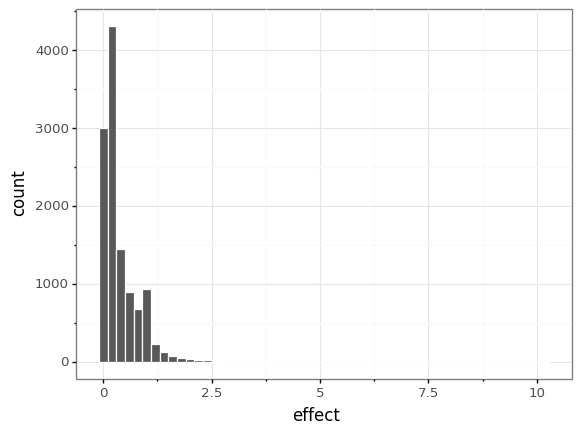

In [8]:
p = ggplot(data=muteffects, mapping=aes(x='effect')) + geom_histogram(color='white', binwidth=.2)
_ = p.draw()

Look at the log2effects to get a better sense of mutational effects:

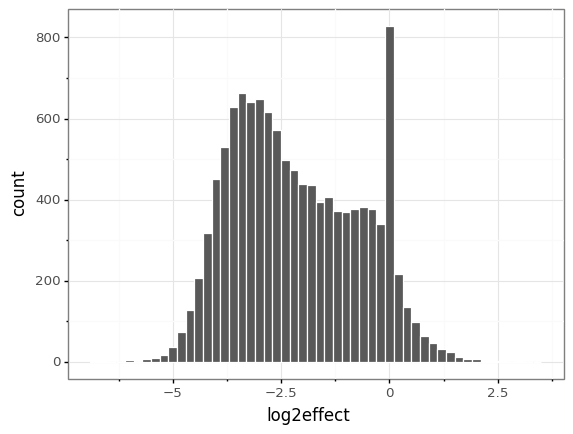

In [9]:
p = ggplot(data=muteffects, mapping=aes(x='log2effect')) + geom_histogram(color='white', binwidth=.2)
_ = p.draw()

This looks like an expected distribution. The hump at around -3 represents mutations with very negative effects, while the hump around 0 represents mutations with small positive or negative effects. We can check where stop codon mutations fall:

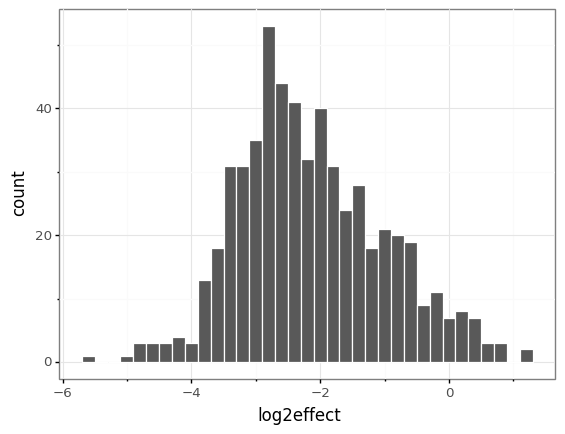

In [10]:
only_stops = muteffects.query("mutant == '*'")
p = ggplot(data=only_stops, mapping=aes(x='log2effect')) + geom_histogram(color='white', binwidth=.2)
_ = p.draw()

It's a little weird that some of the stop codons have a positive effect, but I guess this could just be the late stop codon mutations. We can compare this to the distribution of a different mutation, alanine, which we expect would look like the distribution for all mutations.

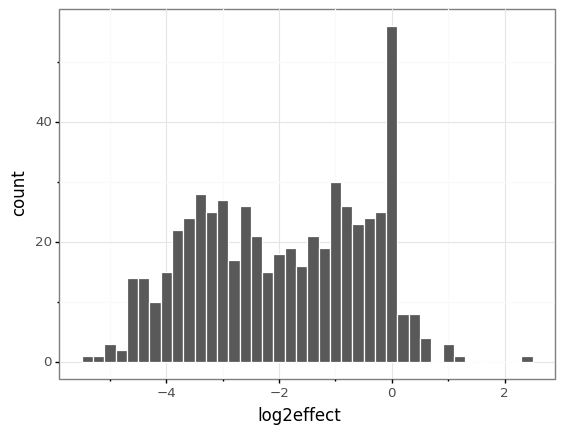

In [11]:
alanines = muteffects.query("mutant == 'A'")
p = ggplot(data=alanines, mapping=aes(x='log2effect')) + geom_histogram(color='white', binwidth=.2)
_ = p.draw()

The easiest approach is to remove all mutations that have an effect below some quantile of stop codon effects. We're using stop codon muteffects for these quantiles because this is our reference for fully deleterious mutations. We can visualize the 75%, 90%, and 95% quantiles of stop codon effects, and where they lie on our full muteffects:

/fh/fast/bloom_j/software/miniconda3/envs/dms_tools2/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/fh/fast/bloom_j/software/miniconda3/envs/dms_tools2/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/effects_quantiles.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


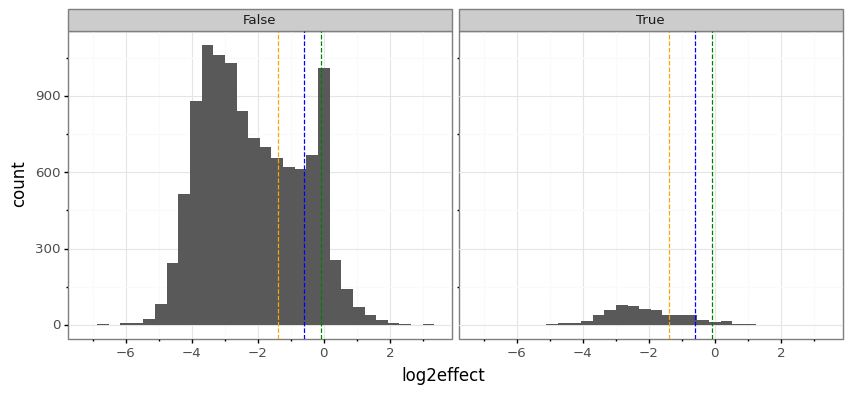

In [13]:
# Using some code from Jesse 
# get cutoff at each quantile
muteffects['is_stop'] = np.where(muteffects['mutant'] == '*', True, False)
quantiles = [0.75, 0.9, 0.95]
quantile_cutoffs = muteffects.query('is_stop')['log2effect'].quantile(quantiles).tolist()
# plot histograms with quantile cutoffs shown for both stop and non-stop mutations
p = (ggplot(muteffects) +
     aes('log2effect') +
     geom_histogram(bins=30) +
     facet_wrap('~ is_stop') +
     theme(figure_size=(10, 4))
    )
for quantile, cutoff, color in zip(quantiles, quantile_cutoffs, ['orange', 'blue', 'green']):
    p = p + geom_vline(xintercept=cutoff, color=color, linetype='dashed')
_ = p.draw()
# you may want to clean up appearance and perhaps add some code to label the different line colors for the quantile cutoffs

ggsave(plot = p, filename = './results/effects_quantiles.png')

How many mutations are kept / cut for each quantile?

In [14]:
n_above_cutoff = (
    pd.concat([muteffects.assign(quantile=quantile, quantile_cutoff=cutoff)
               for quantile, cutoff in zip(quantiles, quantile_cutoffs)])
    .assign(above_cutoff=lambda x: x['log2effect'] > x['quantile_cutoff'])
    .groupby(['quantile', 'is_stop', 'above_cutoff'])
    .aggregate(n_mutations=pd.NamedAgg('mutation', 'count'))
    )
display(n_above_cutoff)

n_mutations
quantile is_stop above_cutoff             
0.75     False   False                7597
                 True                 3743
         True    False                 425
                 True                  142
0.90     False   False                8999
                 True                 2341
         True    False                 510
                 True                   57
0.95     False   False                9915
                 True                 1425
         True    False                 538
                 True                   29

In [15]:
# Assign quantile columns for each mutation for df partitioning
muteffects_quantiles = muteffects
for quantile, cutoff in zip(quantiles, quantile_cutoffs):
    muteffects_quantiles = muteffects_quantiles.assign(
        above_cutoff=lambda x: x['log2effect'] > cutoff).rename(
        columns={'above_cutoff': f"above_{quantile}"})

muteffects_quantiles

,site,wildtype,mutant,mutation,effect,log2effect,is_stop,above_0.75,above_0.9,above_0.95
0,1,M,*,M1*,0.895612,-0.159055,True,True,True,False
1,1,M,A,M1A,0.478744,-1.062673,False,True,False,False
2,1,M,C,M1C,0.967366,-0.047866,False,True,True,True
3,1,M,D,M1D,1.162476,0.217201,False,True,True,True
4,1,M,E,M1E,0.666562,-0.585190,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...
11902,567,*,S,*567S,0.123454,-3.017960,False,False,False,False
11903,567,*,T,*567T,0.108684,-3.201789,False,False,False,False
11904,567,*,V,*567V,0.124720,-3.003234,False,False,False,False
11905,567,*,W,*567W,0.251109,-1.993617,False,False,False,False


In [17]:
# generate df of mutants below the 0.75 quantile, not including stops
del_muts_75quant = muteffects_quantiles[(muteffects_quantiles['above_0.75'] == False) & 
                                (muteffects_quantiles['mutant'] != '*')]

del_muts_75quant = del_muts_75quant.drop(['above_0.75', 'above_0.9', 'above_0.95', 'is_stop'], axis=1)
del_muts_75quant.to_csv('./results/del_muts_75quant.csv', index=False)

del_muts_75quant

,site,wildtype,mutant,mutation,effect,log2effect
13,1,M,P,M1P,0.067935,-3.879703
22,2,K,A,K2A,0.091279,-3.453576
23,2,K,C,K2C,0.200545,-2.318004
24,2,K,D,K2D,0.208715,-2.260392
25,2,K,E,K2E,0.156098,-2.679475
...,...,...,...,...,...,...
11902,567,*,S,*567S,0.123454,-3.017960
11903,567,*,T,*567T,0.108684,-3.201789
11904,567,*,V,*567V,0.124720,-3.003234
11905,567,*,W,*567W,0.251109,-1.993617
